<a href="https://colab.research.google.com/github/zoebatz/CAP6640_Project/blob/main/NLP_gpt_TC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import openai
import pandas as pd
import numpy as np
import os
import kagglehub

from google.colab import userdata

# print(openai.__version__)
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_NLP')

In [106]:
# import data from google drive
file_name = "data_tc2"

path = "/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/"+file_name+".csv"
data = pd.read_csv(path)
data.head()



,Category,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [107]:
len(data)

5573

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
data.value_counts('label')

,count
label,
0,4826
1,747


In [110]:
zero_shot = f""" """

one_shot = f"""
              Input: "do you want to meet downtown at 6? we can get dinner at oak & stone"
              Output: ham
              Input: "Urgent! You’ve Won a $500 Gift Card! Congratulations! You’ve been selected for a $500 prize. Claim now by clicking here: [link]—Offer expires soon!"
              Output: spam
"""

three_shot = f"""
            Input: "Yes let's plan a trip to the grand canyon for this summer."
            Output: ham
            Input: "sorry i missed your call. are you free tonight?"
            Output: ham
            Input: "Hello, I am interested in buying the kayak you have listed. Would you come down to $100?"
            Output: ham
            Input: "Your Account Needs Verification! Dear User, your account has been flagged for security issues. Verify now to avoid suspension: [link]"
            Output: spam
            Input: "You’ve been chosen for a special giveaway! Claim your free gift now before it’s gone: [link]—Limited time only!"
            Output: spam
            Input: "Your premium membership is about to expire! Renew now to avoid losing access: [link]—Offer valid for 24 hours only!"
            Output: spam
"""


In [111]:
# text classification with GPT

def classify_text(text):
    try:
        # Call GPT-3.5 Turbo
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a spam detection agent. Determine if the emails are real (ham) or spam. Respond with only 'ham' for real emails and 'spam' for fake emails. Do not include any other words or symbols."},
                {"role": "assistant", "content": shot},
                {"role": "user", "content": text}
            ]
        )
        # Extract and return the response
        sentiment = response.choices[0].message.content.strip()
#       print(response.choices[0].message.content)
        return sentiment
    except Exception as e:
        return f"Error: {e}"

In [112]:
# adjust for desired prompt / model / data size
test_size = len(data)   # can adjust for smaller testing

function = classify_text
shot_name = "three_shot"      # change for zero / one / three shot
model_name = "gpt-3.5-turbo"  # change for different models

In [113]:

prediction = []

if shot_name == "one_shot":
  shot = one_shot
elif shot_name == "three_shot":
  shot = three_shot
else:
  shot = zero_shot



# text classification
def spam_classification(data):
  count = 0
  for i, texts in enumerate(data.text[:test_size]):
    result = function(texts)
    count += 1
    if count % 50 == 0:
      print(count)

    # Convert result to lowercase for comparison
    result = result.lower()

    if result == 'spam':
      prediction.append(1)

    elif result == 'ham':
      prediction.append(0)

    else:
      # Handle unexpected results, e.g., by appending a default value
      print(f"Unexpected result for text at index {i}: {result}")
      prediction.append(2) # Append 2 as a default for unexpected results




In [114]:
spam_classification(data)


50
Unexpected result for text at index 58: i have determined the nature of the emails:
1. ham
2. ham
3. ham
4. spam
5. spam
6. spam
Unexpected result for text at index 83: ham
ham
ham
spam
spam
spam
100
Unexpected result for text at index 111: research
Unexpected result for text at index 146: i'm sorry, i am not able to answer that question as it is not related to spam detection.
150
Unexpected result for text at index 153: ham
ham
ham
spam
spam
spam
200
250
Unexpected result for text at index 253: i'm here to help you with spam detection. please let me know if you have any emails or messages you'd like me to check.
Unexpected result for text at index 284: ham
ham
ham
spam
spam
spam
Unexpected result for text at index 287: ham
ham
ham
spam
spam
spam
Unexpected result for text at index 293: ham
ham
ham
spam
spam
spam
Unexpected result for text at index 297: ham
ham
ham
300
Unexpected result for text at index 330: ham
ham
ham
spam
spam
spam
350
Unexpected result for text at index 376: ha

In [117]:
len(prediction)

5573

In [118]:
len(data)

5573

In [119]:
# copy predictions to pred_copy
pred_copy = prediction.copy()

In [120]:
# save copy of prediction to google drive
pd.DataFrame(pred_copy).to_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/pred_copy_THREE_shot'+file_name+'.csv', index=False)

In [123]:
# load copy from drive and convert back to list
from_drive = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/pred_copy_THREE_shot'+file_name+'.csv')


In [124]:
# convert from_drive to list
from_drive_list = []
for i in range(len(from_drive)):
  # Convert to Python int using int()
  from_drive_list.append(int(from_drive.iloc[i, 0]))

In [125]:
len(from_drive_list)

5573

In [18]:
file_name

'data_tc2'

In [139]:
# count unexpected results and print
count = 0
for i, pred in enumerate(prediction):
    if pred not in [0, 1]:
        count += 1
 #       print(f"Unexpected result for text at index {i}: {pred}")

print(count)

87


In [138]:
prediction = pred_copy.copy()

In [140]:
# combine count unexpected with options for handling

handle_option = 1 # 0 = change all to 0 / 1 = remove
indices_to_remove = []
count = 0

if file_name == "data_tc1":
  for i, pred in enumerate(prediction):
      if pred not in ['romance', 'horror', 'comedy', 'action']:
          count += 1
          if handle_option == 0:
              prediction[i] = 'romance'
          elif handle_option == 1:
              indices_to_remove.append(i)



if file_name == "data_tc2":
  for i, pred in enumerate(prediction):
      if pred not in [0, 1]:
          count += 1
          if handle_option == 0:
              prediction[i] = 0
          elif handle_option == 1:
              indices_to_remove.append(i)



#print(indices_to_remove)
print(count)

if handle_option == 1:
    # Remove rows from data and prediction outside the loop
    data.drop(data.index[indices_to_remove], inplace=True)
    prediction = [pred for i, pred in enumerate(prediction) if i not in indices_to_remove]




[58, 83, 111, 146, 153, 253, 284, 287, 293, 297, 330, 376, 505, 509, 514, 582, 658, 717, 996, 1083, 1130, 1189, 1237, 1273, 1319, 1363, 1427, 1483, 1716, 1849, 1883, 1925, 2124, 2143, 2182, 2246, 2336, 2345, 2351, 2509, 2544, 2571, 2599, 2602, 2621, 2660, 2688, 2721, 2754, 2827, 2874, 2917, 3051, 3250, 3394, 3414, 3492, 3665, 3775, 3787, 3833, 3901, 4014, 4244, 4255, 4273, 4342, 4356, 4360, 4365, 4486, 4498, 4502, 4622, 4721, 4859, 4870, 4887, 5011, 5072, 5081, 5089, 5188, 5326, 5357, 5428, 5433]


In [141]:
len(prediction)

5486

In [142]:
len(data)

5486

In [143]:
file_name

'data_tc2'

In [144]:
shot_name


'three_shot'

In [145]:
handle_option

1

In [146]:
# view metrics and save
def view_and_save_metrics(data, predicted_classes):
  accuracy = accuracy_score(data.tolist(), predicted_classes)
  precision = precision_score(data.tolist(), predicted_classes)
  recall = recall_score(data.tolist(), predicted_classes)
  f1 = f1_score(data.tolist(), predicted_classes)
  conf_matrix = confusion_matrix(data.tolist(), predicted_classes)
  #roc_auc = roc_auc_score(data.tolist(), predicted_classes)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)
  #print("ROC AUC Score:", roc_auc)

  metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "confusion_matrix": conf_matrix,
  #    "roc_auc_score": roc_auc,
      "model_name": model_name,
      "dataset": file_name
  }

  # save metrics to csv file
  metrics_df = pd.DataFrame([metrics])
  metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/metrics_'+model_name+'_'+file_name+'_'+shot_name+'_'+str(handle_option)+'.csv', index=False)




In [147]:
view_and_save_metrics(data.label, prediction)

Accuracy: 0.9123222748815166
Precision: 0.6121057118499573
Recall: 0.9650537634408602
F1 Score: 0.7490871152842984
Confusion Matrix:
 [[4287  455]
 [  26  718]]


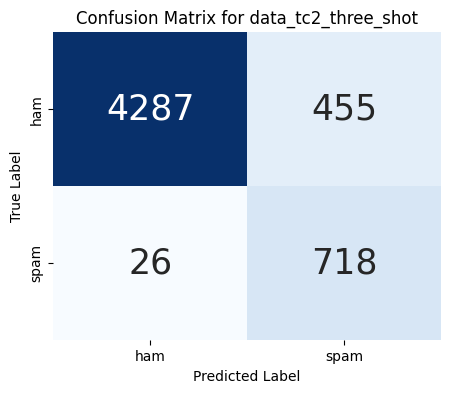

In [148]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.label, prediction)

# Define class labels
labels = ["ham", "spam"]

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 25}, xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {file_name}_{shot_name}")
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/confusion_matrix_{file_name}_{shot_name}_{handle_option}.png")
plt.show()

